In [1]:
import chipwhisperer as cw
import matplotlib.pyplot as plt
import numpy as np

import simon_64_128
import simon_64_128_simulation

from helper import KeyHypothesis
import helper
import correlations

from measurement import Measurements, Measurement

/home/nico/miniconda3/envs/simon/lib/python3.13/site-packages/chipwhisperer/capture/trace/TraceWhisperer.py:31: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources # type: ignore


# Import Trace

In [2]:
project = cw.import_project("./traces/13_simon_leakage_50000/trace.zip", overwrite=True)

In [3]:
NUM_MEASUREMENTS = len(project.traces) // 2
VALS_PER_MEASUREMENT = len(project.traces[0].wave)

print(NUM_MEASUREMENTS)
print(VALS_PER_MEASUREMENT)

50000
5000


# Transform Trace Project into Measurement object

In [5]:
%matplotlib widget

plaintexts1 = np.zeros((NUM_MEASUREMENTS, 2), dtype=np.uint32)
ciphertexts1 = np.zeros((NUM_MEASUREMENTS, 2), dtype=np.uint32)
powers1 = np.zeros((NUM_MEASUREMENTS, VALS_PER_MEASUREMENT), dtype=np.uint32)

plaintexts2 = np.zeros((NUM_MEASUREMENTS, 2), dtype=np.uint32)
ciphertexts2 = np.zeros((NUM_MEASUREMENTS, 2), dtype=np.uint32)
powers2 = np.zeros((NUM_MEASUREMENTS, VALS_PER_MEASUREMENT), dtype=np.uint32)

for i, trace in enumerate(project.traces):

    pt = trace.textin
    ct = trace.textout

    if i % 2 == 0:
        plaintexts1[i//2,0] = pt[0] << 24 | pt[1] << 16 | pt[2] << 8 | pt[3]
        plaintexts1[i//2,1] = pt[4] << 24 | pt[5] << 16 | pt[6] << 8 | pt[7]

        ciphertexts1[i//2,0] = ct[0] << 24 | ct[1] << 16 | ct[2] << 8 | ct[3]
        ciphertexts1[i//2,1] = ct[4] << 24 | ct[5] << 16 | ct[6] << 8 | ct[7]
        powers1[i//2,:] = trace.wave

    else:
        plaintexts2[i//2,0] = pt[0] << 24 | pt[1] << 16 | pt[2] << 8 | pt[3]
        plaintexts2[i//2,1] = pt[4] << 24 | pt[5] << 16 | pt[6] << 8 | pt[7]

        ciphertexts2[i//2,0] = ct[0] << 24 | ct[1] << 16 | ct[2] << 8 | ct[3]
        ciphertexts2[i//2,1] = ct[4] << 24 | ct[5] << 16 | ct[6] << 8 | ct[7]
        powers2[i//2,:] = trace.wave

measurements1 = Measurements(plaintexts1, ciphertexts1, powers1)
measurements2 = Measurements(plaintexts2, ciphertexts2, powers2)

In [6]:
key = np.array([0xad828bc8, 0x3bada07c, 0xc80bf12f, 0x75c03156], dtype=np.uint32)
pt = measurements1[0].plaintext
ct = measurements1[0].ciphertext

ct_expect, _ = simon_64_128.encrypt_block(pt, key)

print(hex(pt[0]), hex(pt[1]))
print(hex(ct[0]), hex(ct[1]))
print(hex(ct_expect[0]), hex(ct_expect[1]))

0x194cd4c1 0x41fb0437
0x3fe6fecf 0xc5f97603
0x3fe6fecf 0xc5f97603


In [7]:
print(measurements1.plaintext.shape)
print(measurements1.ciphertext.shape)
print(measurements1.power.shape)

print(measurements2.plaintext.shape)
print(measurements2.ciphertext.shape)
print(measurements2.power.shape)

(50000, 2)
(50000, 2)
(50000, 5000)
(50000, 2)
(50000, 2)
(50000, 5000)


# Welch's Test

In [12]:
mean1 = np.mean(measurements1.power, axis=0)
std1 = np.std(measurements1.power, axis=0)

mean2 = np.mean(measurements2.power, axis=0)
std2 = np.std(measurements2.power, axis=0)  


t = (mean1 - mean2) / np.sqrt((std1**2 + std2**2) / NUM_MEASUREMENTS)
print(t.shape)

print(np.max(t))
print(np.min(t))

(5000,)
72.66443090732693
-10.35912566893987


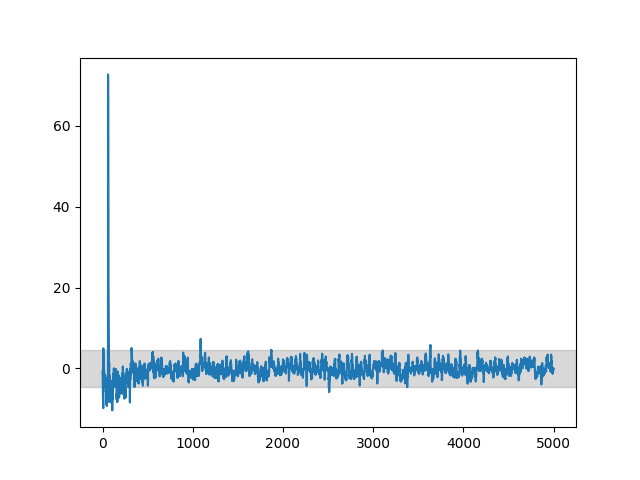

In [16]:
%matplotlib widget

plt.figure()

plt.plot(t)
plt.axhspan(-4.5, 4.5, color='grey', alpha=0.3)

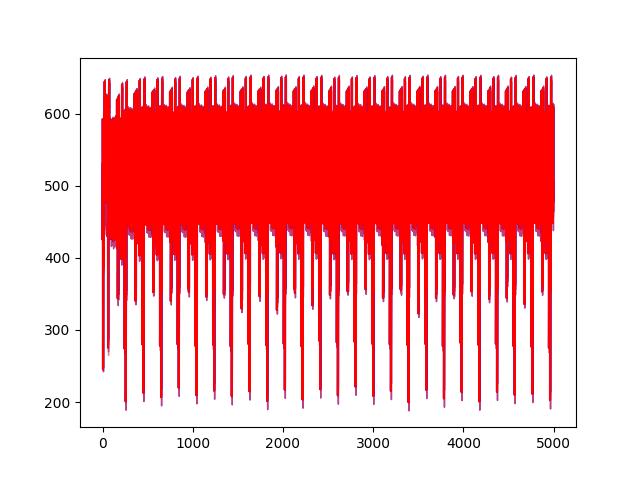

In [15]:
%matplotlib widget
plt.figure()

plt.plot(mean1, color='blue')
plt.fill_between(range(len(mean1)), mean1 - std1, mean1 + std1, color='blue', alpha=0.5)

plt.plot(mean2, color='red')
plt.fill_between(range(len(mean2)), mean2 - std2, mean2 + std2, color='red', alpha=0.5)